In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import patsy as pt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
import math
import statistics
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')

In [2]:
data = pd.read_csv('26.02.21.csv', sep=';')

In [4]:
rounds_num = 10
player_num = 26

## Функции

In [5]:
def v_list(player):
    
    vlist = []
    subdata = data[(data['participant.id_in_session'] == player) & (data['player.id_in_group'] == 1)]
    
    for index, row in subdata.iterrows():
        vlist.append(row['player.v1'])
        vlist.append(row['player.v2'])
        vlist.append(row['player.v3'])
        
    return vlist

In [6]:
def c_list(player):
    
    clist = []
    subdata = data[(data['participant.id_in_session'] == player) & (data['player.id_in_group'] == 2)]
    
    for index, row in subdata.iterrows():
        clist.append(row['player.v1'])
        clist.append(row['player.v2'])
        clist.append(row['player.v3'])
        
    return clist

In [7]:
def qv_list(player):
    
    qvlist = []
    subdata = data[(data['participant.id_in_session'] == player) & (data['player.id_in_group'] == 1)]
    
    for index, row in subdata.iterrows():
        qvlist.append(row['player.q1'])
        qvlist.append(row['player.q2'])
        qvlist.append(row['player.q3'])
        
    return qvlist

In [8]:
def qc_list(player):
    
    qclist = []
    subdata = data[(data['participant.id_in_session'] == player) & (data['player.id_in_group'] == 2)]
    
    for index, row in subdata.iterrows():
        qclist.append(row['player.q1'])
        qclist.append(row['player.q2'])
        qclist.append(row['player.q3'])
        
    return qclist

In [9]:
# Рисование графиков Q(c) (покупатель) для всех игроков
def Qc():
    
    plt.figure(figsize = (13, 20))
    
    for player in np.arange(1, 27):
        plt.subplot(6, 5, player)
        
        x = c_list(player)
        y = qc_list(player)
        plt.scatter(x, y, linewidth = 1)    
        plt.title(pl_data[player]['name'])

In [10]:
# Рисование графиков Q(v) (продавец) для всех игроков
def Qv():
    
    plt.figure(figsize = (13, 20))
    
    for player in np.arange(1, 27):
        plt.subplot(6, 5, player)
        
        x = v_list(player)
        y = qv_list(player)
        plt.scatter(x, y, linewidth = 1)    
        plt.title(pl_data[player]['name'])

In [11]:
# Считает дельту игрока в каждой сделке
def deltas(player):
    
    deltas = []
    subdata = data[data['participant.id_in_session'] == player]
    
    for index, row in subdata.iterrows():
        if row['player.id_in_group'] == 1:
            delta1 = row['player.oq1'] - row['player.q1']
            delta2 = row['player.oq2'] - row['player.q2']
            delta3 = row['player.oq3'] - row['player.q3']
        else:
            delta1 = row['player.q1'] - row['player.oq1']
            delta2 = row['player.q2'] - row['player.oq2']
            delta3 = row['player.q3'] - row['player.oq3']
        deltas.append(delta1)
        deltas.append(delta2)
        deltas.append(delta3)
    
    return deltas

In [12]:
# Считает долю заключенных сделок для игрока
def deal_rate(player):
    
    subdata = data[data['participant.id_in_session'] == player]
    count = 0
    
    for index, row in subdata.iterrows():
        count = count + row['player.deal1'] + row['player.deal2'] + row['player.deal3']
    
    return count/30

In [13]:
# Считает маржу за продавца
def smargin(player):
    
    subdata = data[(data['participant.id_in_session'] == player) & (data['player.id_in_group'] == 1)]
    smargins = []
    
    for index, row in subdata.iterrows():
        smargins.append(row['player.q1'] - row['player.v1'])
        smargins.append(row['player.q2'] - row['player.v2'])
        smargins.append(row['player.q3'] - row['player.v3'])
    
    return smargins

In [14]:
# Считает маржу за покупателя
def bmargin(player):
    
    subdata = data[(data['participant.id_in_session'] == player) & (data['player.id_in_group'] == 2)]
    bmargins = []
    
    for index, row in subdata.iterrows():
        bmargins.append(row['player.v1'] - row['player.q1'])
        bmargins.append(row['player.v2'] - row['player.q2'])
        bmargins.append(row['player.v3'] - row['player.q3'])
    
    return bmargins

In [15]:
# Считает для игрока долю возможных, но не состоявшихся по его вине сделок
def lose_rate(player):
    
    subdata = data[(data['participant.id_in_session'] == player)]
    count = 0
    
    for index, row in subdata.iterrows():
        if row['player.id_in_group'] == 1:
            if (row['player.deal1'] == 0) & (row['player.oq1'] >= row['player.v1']):
                count = count + 1
            if (row['player.deal2'] == 0) & (row['player.oq2'] >= row['player.v2']):
                count = count + 1
            if (row['player.deal3'] == 0) & (row['player.oq3'] >= row['player.v3']):
                count = count + 1
        if row['player.id_in_group'] == 2:
            if (row['player.deal1'] == 0) & (row['player.v1'] >= row['player.oq1']):
                count = count + 1
            if (row['player.deal2'] == 0) & (row['player.v2'] >= row['player.oq2']):
                count = count + 1
            if (row['player.deal3'] == 0) & (row['player.v3'] >= row['player.oq3']):
                count = count + 1
            
    
    return count/30

In [ ]:
# Строит выявленные графики для периода
def det_graphics(n):
    
    subdata = data[data['subsession.round_number']==n]
    
    sub1 = subdata[subdata['player.id_in_group']==1]
    sale = list(sub1['player.q1']) + list(sub1['player.q2']) + list(sub1['player.q3'])
    sale.sort()
    
    sub2 = subdata[subdata['player.id_in_group']==2]
    buy = list(sub2['player.q1']) + list(sub2['player.q2']) + list(sub2['player.q3'])
    buy.sort(reverse=True)
    
    price = [(x + y)/2 for x, y in zip(sale, buy) if y >= x]
    
    
 
    x = np.arange(len(sale))
    plt.plot(x, sale, color = 'crimson', linewidth = 1, label='Предложение')
    
    x = np.arange(len(buy))
    plt.plot(x, buy, color = 'yellow', linewidth = 1, label='Спрос')
    
    x = np.arange(len(price))
    plt.plot(x, price, color = 'blue', linewidth = 1, label='Цена')

    
    
    plt.grid()
    plt.legend()
    plt.show()

In [88]:
# Строит графики выявленные и v и c для периода
def graphics(n):
    
    subdata = data[data['subsession.round_number']==n]
    
    sub1 = subdata[subdata['player.id_in_group']==1]
    sale = list(sub1['player.q1']) + list(sub1['player.q2']) + list(sub1['player.q3'])
    sale.sort()
    v = list(sub1['player.v1']) + list(sub1['player.v2']) + list(sub1['player.v3'])
    v.sort()
    
    sub2 = subdata[subdata['player.id_in_group']==2]
    buy = list(sub2['player.q1']) + list(sub2['player.q2']) + list(sub2['player.q3'])
    buy.sort(reverse=True)
    c = list(sub2['player.v1']) + list(sub2['player.v2']) + list(sub2['player.v3'])
    c.sort(reverse=True)
    
    price = [(x + y)/2 for x, y in zip(sale, buy) if y >= x]
    
    plt.figure(figsize = (13, 10))
    x = np.arange(len(sale))
    plt.plot(x, sale, color = 'darkorange', linewidth = 1, label='Предложение')
    x = np.arange(len(buy))
    plt.plot(x, buy, color = 'blue', linewidth = 1, label='Спрос')
    x = np.arange(len(price))
    plt.plot(x, price, color = 'crimson', linewidth = 1.5, label='Цена')    
    x = np.arange(len(v))
    plt.plot(x, v, color = 'brown', linestyle = '--', linewidth = 1.3, label='В.с. продавца')
    x = np.arange(len(c))
    plt.plot(x, c, color = 'darkblue', linestyle = '--', linewidth = 1.3, label='В.с. покупателя')
    
    
    plt.title(f"Кривые спроса и предложения для периода {n}")
    plt.grid()
    plt.legend()
    plt.show()

In [73]:
def all_info():
    
    efficiency = []
    volumes = []
    potentials = []
    
    plt.figure(figsize = (13, 30))
    
    for n in np.arange(1, 11):
        
        subdata = data[data['subsession.round_number']==n]
        
        sub1 = subdata[subdata['player.id_in_group']==1]
        sale = list(sub1['player.q1']) + list(sub1['player.q2']) + list(sub1['player.q3'])
        sale.sort()
        v = list(sub1['player.v1']) + list(sub1['player.v2']) + list(sub1['player.v3'])
        v.sort()
        
        sub2 = subdata[subdata['player.id_in_group']==2]
        buy = list(sub2['player.q1']) + list(sub2['player.q2']) + list(sub2['player.q3'])
        buy.sort(reverse=True)
        c = list(sub2['player.v1']) + list(sub2['player.v2']) + list(sub2['player.v3'])
        c.sort(reverse=True)
        
        price = [(x + y)/2 for x, y in zip(sale, buy) if y >= x]
        

        volume = sum([x - y for x, y in zip(buy, sale) if x >= y])
        potential = sum([x - y for x, y in zip(c, v) if x >= y])
        efficiency.append(volume/potential)
        volumes.append(volume)
        potentials.append(potential)
        
        
        plt.subplot(5, 2, n)
        x = np.arange(len(sale))
        plt.plot(x, sale, color = 'orange', linewidth = 1, label='Предложение')
        x = np.arange(len(buy))
        plt.plot(x, buy, color = 'blue', linewidth = 1, label='Спрос')
        x = np.arange(len(price))
        plt.plot(x, price, color = 'crimson', linewidth = 1.5, label='Цена')    
        x = np.arange(len(v))
        plt.plot(x, v, color = 'brown', linestyle = '--', linewidth = 1.3, label='В.с. продавца')
        x = np.arange(len(c))
        plt.plot(x, c, color = 'darkblue', linestyle = '--', linewidth = 1.3, label='В.с. покупателя')
        
        
        plt.title(f"Кривые спроса и предложения для периода {n}")
        plt.xlabel(f'эффективность рынка = {volume/potential:.2f}')
        plt.grid()
        plt.legend()
        
    plt.figure(figsize = (10, 5))
    x = np.arange(1, 11)
    plt.plot(x, efficiency, color = 'purple', linestyle = '-.', linewidth = 1.5)
    plt.title('Динамика эффективности рынка')
    plt.xlabel('Номер периода')
    plt.ylabel('Доля объёма торговли')
    plt.show()
    
    massiv = np.array([potentials, volumes])
    table = pd.DataFrame(massiv, columns = np.arange(1, 11), index=['Потенциальный объём', 'Фактический объём'])
    return table

## Словарь с игроками

pl_data[participant.id_in_session] = Имя игрока, delta_avg, deal_rate, smargin_avg, bmargin_avg, lose_rate

In [24]:
ids = []
names = []
subdata = data[data['subsession.round_number']==1]
for index, row in subdata.iterrows():
    ids.append(row['participant.id_in_session'])
    names.append(row['participant.label'])

players = set(data['participant.label'])
    
pl_data = {}
for i in range(len(players)):
    pl_data[ids[i]] = {} 
    
for index, name in zip(ids, names):
    pl_data[index]['name'] = name

In [25]:
for player in pl_data:
    pl_data[player]['delta_avg'] = np.mean(deltas(player))

In [26]:
for player in pl_data:
    pl_data[player]['deal_rate'] = deal_rate(player)

In [27]:
for player in pl_data:
    pl_data[player]['smargin_avg'] = np.mean(smargin(player))

In [28]:
for player in pl_data:
    pl_data[player]['bmargin_avg'] = np.mean(bmargin(player))

In [29]:
'''
for player in pl_data:
    pl_data[player].pop('deal_rate', None)
    
pl_data
'''

"\nfor player in pl_data:\n    pl_data[player].pop('deal_rate', None)\n    \npl_data\n"

In [30]:
for player in pl_data:
    pl_data[player]['lose_rate'] = lose_rate(player)

In [31]:
for player in pl_data:
    pl_data[player]['v'] = np.mean(v_list(player))
for player in pl_data:
    pl_data[player]['Q(v)'] = np.mean(qv_list(player))
for player in pl_data:
    pl_data[player]['c'] = np.mean(c_list(player))
for player in pl_data:
    pl_data[player]['Q(c)'] = np.mean(qc_list(player))

In [32]:
dict_list = []
for player in pl_data:
    dict_list.append(pl_data[player])

players = pd.DataFrame(dict_list)

In [33]:
players['payoff'] = data['participant.payoff']

## Информация о рынке

Ниже приведены графики с базовыми и выявленными кривыми спроса и предложения по каждому периоду. Под каждым графиком подсчитана эффективность рынка за этот период – отношение объёма общей торговли на рынке за период к потенциально возможной.
Снизу приведён график, демонстрирующий динамику эффективности рынка во времени. Как можно видеть, за всё время эксперимента эффективность рынка ни разу не превысила и 50%.
Интересно, что явного вида у кривой этой зависимости нет. Если и предполагать её форму, то она выглядит как парабола с горбом посередине. То есть, за всё время эксперимента общая масса игроков мало того, что не увеличила общую эффективность, так ещё и едва вернулась к концу игр на изначальный показатель.

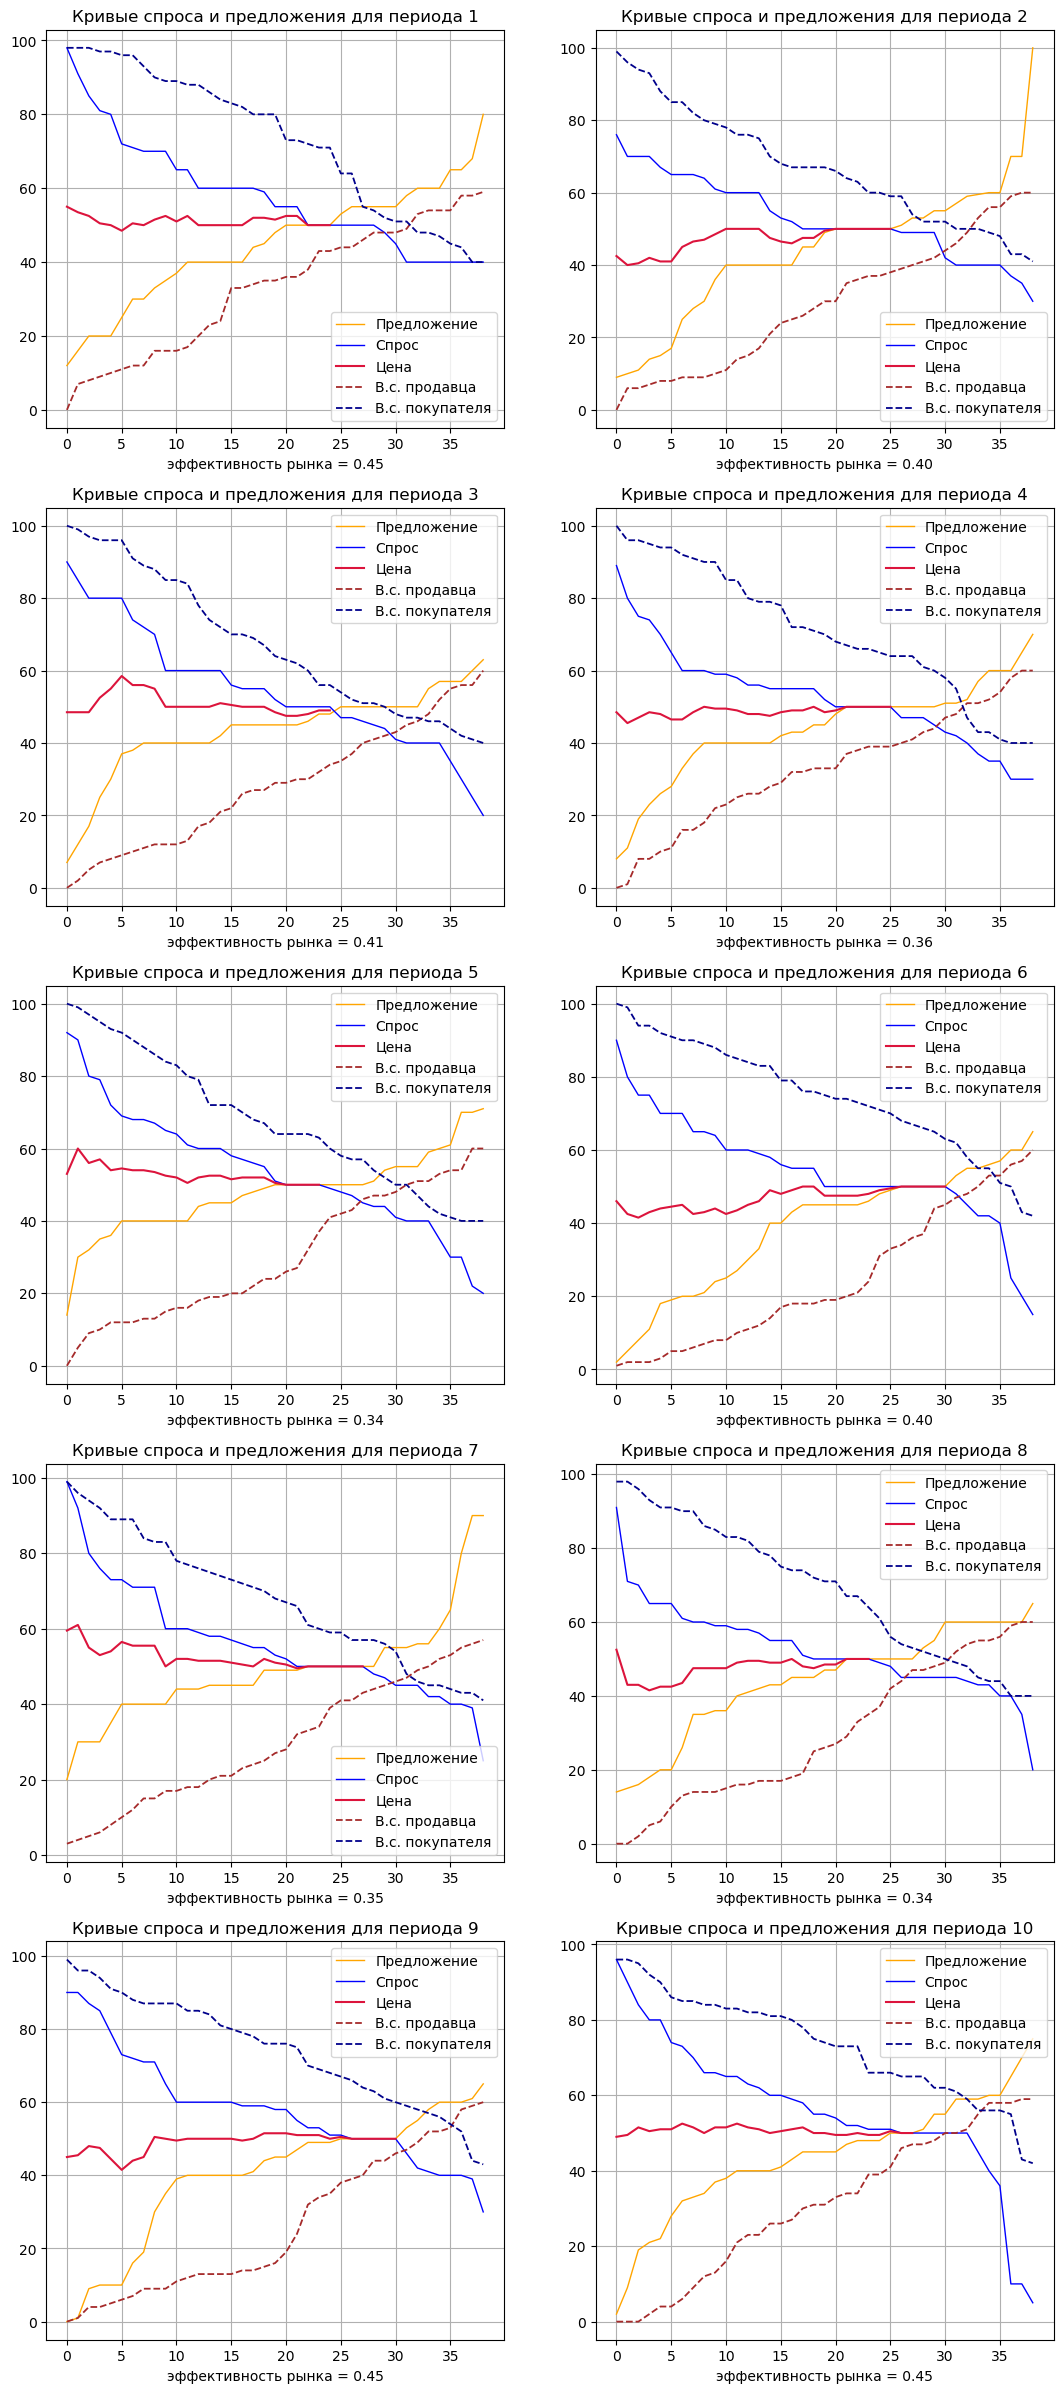

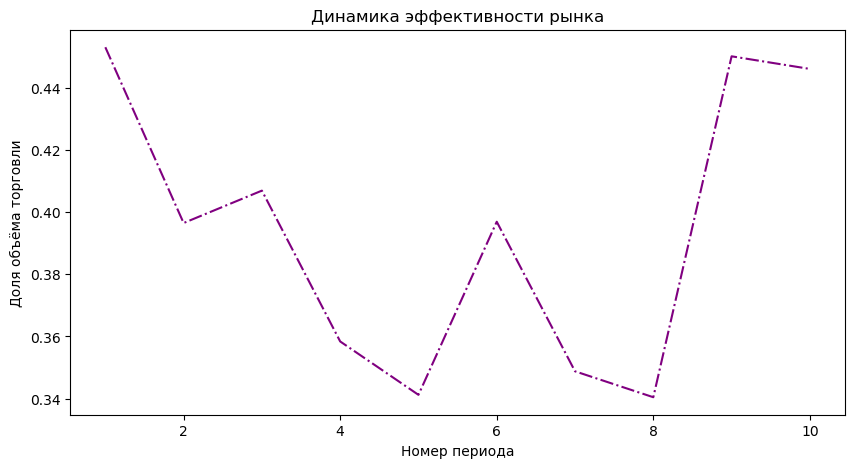

,1,2,3,4,5,6,7,8,9,10
Потенциальный объём,1649.0,1536.0,1595.0,1582.0,1559.0,1998.0,1551.0,1633.0,1913.0,1686.0
Фактический объём,747.0,609.0,649.0,567.0,532.0,793.0,541.0,556.0,861.0,752.0


In [74]:
plt.rcParams.update(plt.rcParamsDefault)

table = all_info()
table

## Информация об игроках

Ниже представлена общая таблица с некоторыми характеристиками всех игроков.

In [375]:
players

,name,delta_avg,deal_rate,smargin_avg,bmargin_avg,lose_rate,v,Q(v),c,Q(c),payoff
0,Меньшикова Ольга,11.333333,0.833333,18.250000,13.500000,0.033333,27.291667,45.541667,72.166667,58.666667,706
1,Камалов Ринат Альбердович,1.566667,0.766667,20.333333,16.222222,0.100000,26.250000,46.583333,65.611111,49.388889,533
2,Шалимов Валентин,40.766667,0.833333,4.400000,3.066667,0.000000,36.466667,40.866667,84.266667,81.200000,746
3,Александр Чабан,16.133333,0.800000,7.083333,11.055556,0.033333,32.750000,39.833333,66.055556,55.000000,546
4,Аминов Тимур,35.500000,0.766667,0.000000,0.000000,0.000000,28.750000,28.750000,68.166667,68.166667,567
5,Кучеренко Тамара,2.633333,0.600000,22.222222,17.250000,0.166667,28.333333,50.555556,71.250000,54.000000,585
6,Галиева Мадина Айдаровна,18.900000,0.800000,7.761905,14.666667,0.033333,30.047619,37.809524,68.222222,53.555556,604
7,Негримовский Дмитрий,23.766667,0.733333,1.277778,4.833333,0.000000,27.722222,29.000000,59.666667,54.833333,490
8,Власов Александр Анатольевич,27.800000,0.766667,7.133333,15.466667,0.000000,30.533333,37.666667,78.333333,62.866667,774
9,Гупте Сиддхартха,-4.700000,0.366667,18.444444,16.857143,0.300000,29.666667,48.111111,64.142857,47.285714,355


Рассмотрим какую маржу в качестве продавца устанавливали игроки, отсротируем по этому признаку (smargin_avg).
Прекрасно видно, что встречались различные стратегии как с большой маржой в 35, так и с минимальной нулевой.
Забегая вперёд, можно сказать, что в явную группу со схожим поведением выделяются игроки Аминов Тимур, Молчанова Вероника, Негримовский Дмитрий, устанавливающие почти минимальную маржу и в качестве продавца, и в качестве покупателя (bmargin_avg), а в противовес им выделяется Борисов Никита, устанавливавший максимальную из всех маржу в обеих ролях.

In [376]:
players.sort_values(by='smargin_avg', ascending=False)

,name,delta_avg,deal_rate,smargin_avg,bmargin_avg,lose_rate,v,Q(v),c,Q(c),payoff
23,Борисов Никита,-30.666667,0.166667,35.250000,43.444444,0.433333,30.583333,65.833333,70.555556,27.111111,221
16,Филиппова Валерия Михайловна,16.833333,0.566667,23.133333,8.066667,0.333333,23.666667,46.800000,73.066667,65.000000,456
5,Кучеренко Тамара,2.633333,0.600000,22.222222,17.250000,0.166667,28.333333,50.555556,71.250000,54.000000,585
17,Липкин Константин,10.266667,0.766667,22.222222,18.000000,0.066667,23.888889,46.111111,72.571429,54.571429,705
18,Тихонова Антонина,-4.083333,0.700000,21.092593,24.333333,0.100000,30.555556,51.648148,74.333333,50.000000,539
20,Михайлова Анна,3.733333,0.666667,20.600000,21.533333,0.166667,26.066667,46.666667,70.866667,49.333333,593
1,Камалов Ринат Альбердович,1.566667,0.766667,20.333333,16.222222,0.100000,26.250000,46.583333,65.611111,49.388889,533
9,Гупте Сиддхартха,-4.700000,0.366667,18.444444,16.857143,0.300000,29.666667,48.111111,64.142857,47.285714,355
0,Меньшикова Ольга,11.333333,0.833333,18.250000,13.500000,0.033333,27.291667,45.541667,72.166667,58.666667,706
22,Малин Алексей Владимирович,3.233333,0.633333,18.066667,18.666667,0.100000,25.933333,44.000000,66.600000,47.933333,613


На следующих графиках приведены зависимости заявок, которые делали игроки в роли покупателя, от выкупной стоимости.
У игроков Шалимов, Аминов, Негримовский, Сиддхартха, Молчанова, Тимакова, Морозов наблюдается явная линейная зависимость заявки от выкупной стоимости.
Стратегии игроков Чабан, Меньшикова (мало точек), Павлов, Белоконь, Сафина имеют вид либо просто вогнутой функции, либо вогнутой функции переходящей местами в константу.
Самыми дисперсными стратегиями, судя по графикам, обладают Камалов, Колягина, Борисов.

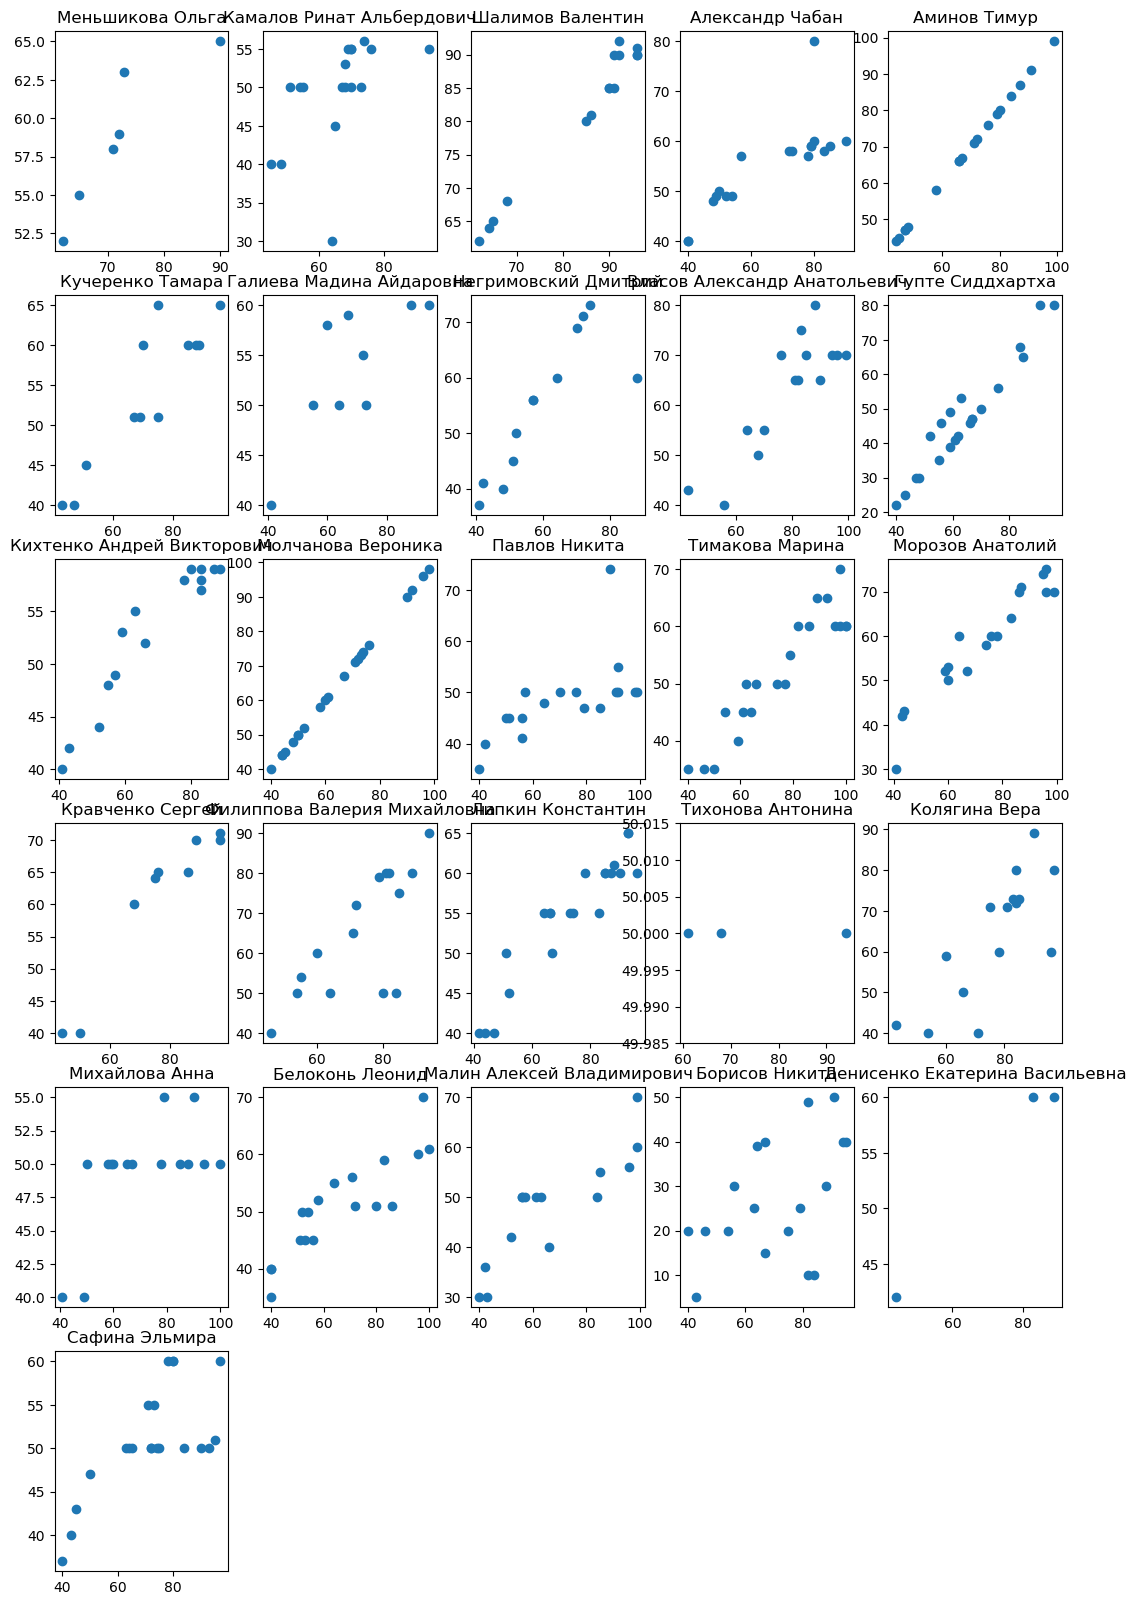

In [423]:
Qc()

Замечания аналогичного характера можно провести и в отношении стратегий игроков в роли продавца.

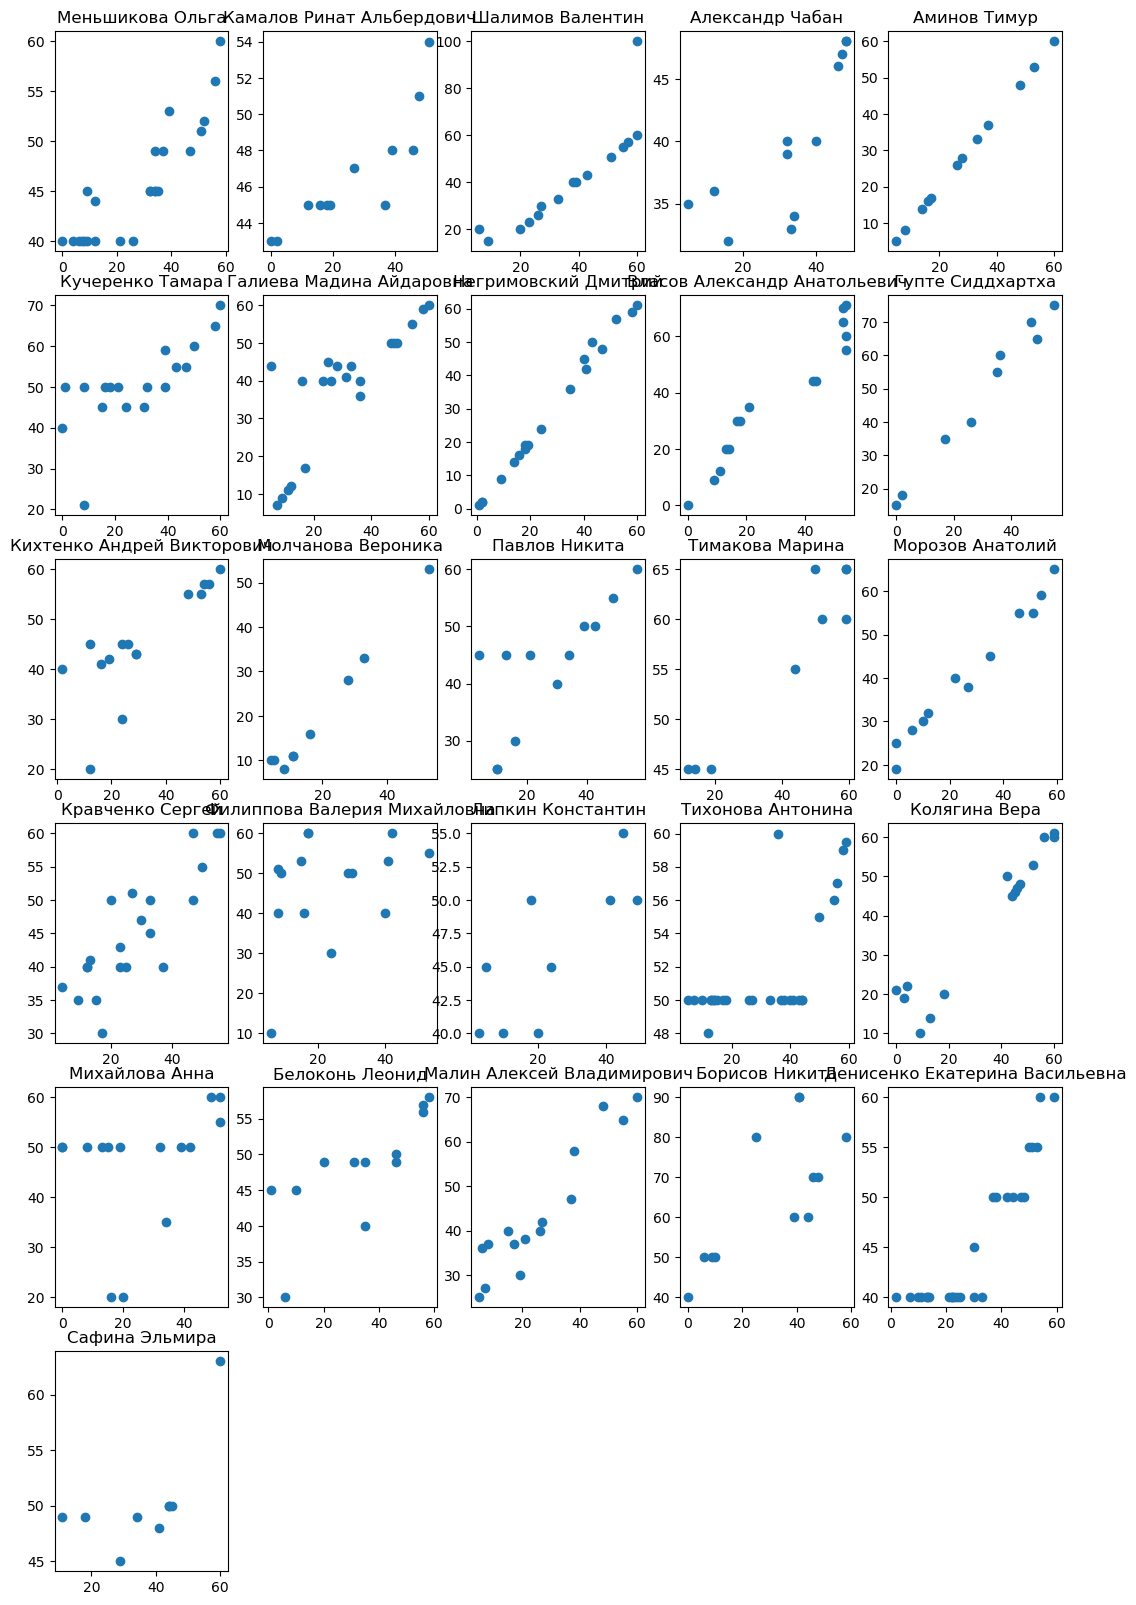

In [424]:
Qv()

##  Личное поведение

Моя собственная стратегия, как уже стало ясно, относится к первой оглашённой группе. Я рассудил так, что тем больше заработаю, чем более выгодных партнёров получу для своих сделок, поэтому делал заявку равную выкупной стоимости, либо отличающуюся от неё максимум на несколько единиц.

У меня нет явного ответа на вопрос, как действительно стоило действовать в данной игре, как автоматизировать стратегию, кроме, разве что, соображения, что максимизация маржи здесь было явно проигрышной стратегией.

Как можно видеть из графиков, во все периоды и кривая спроса, и кривая предложения (пунктирные) по форме близки к прямым, что соответствует теоретическому распределению. Но, в то же время, форму кривых выявленного спроса и выявленного предложения прямыми назвать никак нельзя. Они похожи на вогнутые к оси симметрии всей картины, располагающейся на высоте ≈50, кривые почти во всех периодах.

Если пытаться ориентироваться на наблюдаемую тенденцию, то я бы постарался следующим образом автоматизировать стратегию.
Без нарушения общности допустим, что мы играем за продавца. После получения выкупной стоимости нам нужно обнаружить, на каком участке предполагаемой кривой выявленного спроса мы находимся.
Это нужно для того, чтобы понять угол наклона кривой выявленного спроса в точке расположения нашей выкупной стоимости.
Так как такая вогнутая форму сложна для описания, я думаю, что можно аппроксимировать эти кривые кусочно-линейно функцией из двух участков: более крутого ближе к нулю по оси Ох и более пологого ближе к точке пересечения двух кривых. У этой функции, соответственно, будет пороговая точка $x^*$.

После этого интуитивные соображения следующие: если выкупная стоимость v находится по Ox на крутом участке функции, то стоит делать заявку, равную v, так как на крутом участке каждая сниженная единица заявки продавца гарантирует ему большее количество единиц выгоды от более выгодного партнёра (большее, т к участок крутой). Если же выкупная стоимость v находится по Ox на пологом участке функции, то имеет смысл добавить к v некоторую маржу, но без фанатизма.

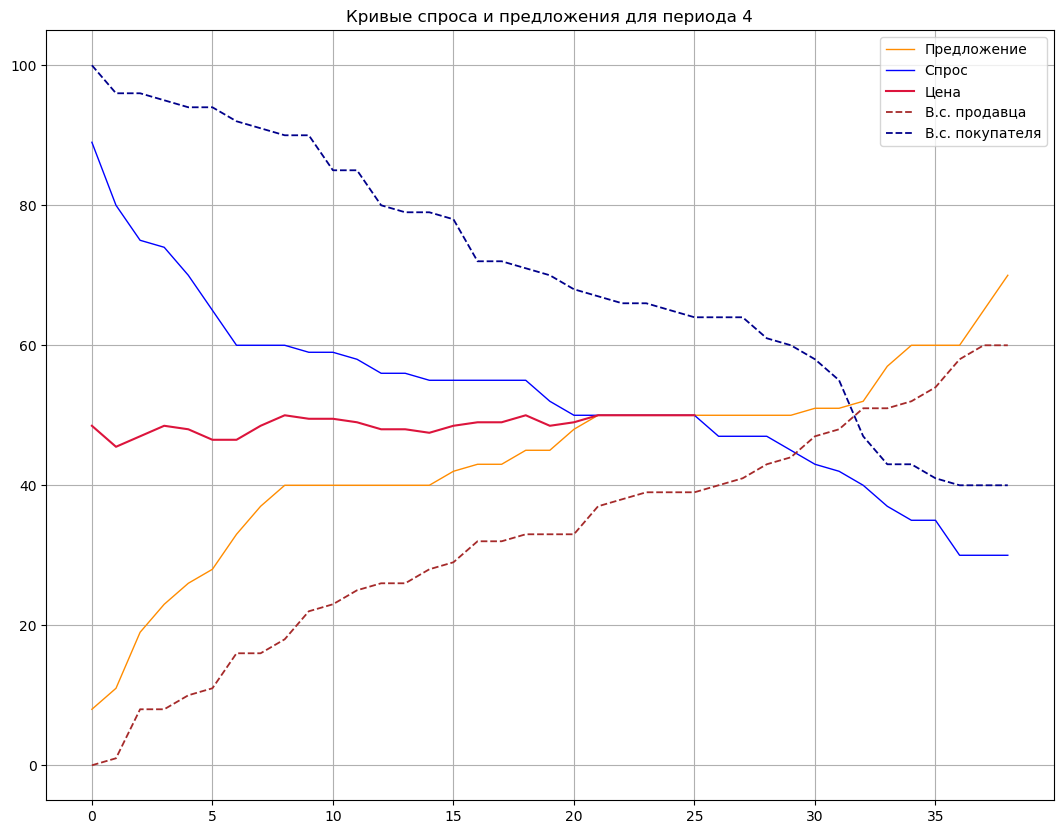

In [89]:
graphics(4)